### ДЗ - Плотников Святослав

In [185]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import pandas as pd
import hashlib
import sklearn
from scipy.stats import norm

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

<ipython-input-2-57f4fc94f2aa>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# 📺 Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [11]:
interactions = pd.read_csv('interactions.csv')
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [12]:
interactions.head(5).append(interactions.tail())

/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_14872/1162599782.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  interactions.head(5).append(interactions.tail())


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [16]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [30]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [382]:
week21 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]
week2 = week21.groupby('user_id', as_index=False).agg({'total_dur': sum})

### В days беру 13 дней потому что просят с 2021-08-09, а если взять days = 14 будет с 2021-08-08, видимо этот метод берет на один день больше

In [120]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use 
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/ 
# Делим на 2 равные группы 
def groups_splitter(df, columns, user_salt):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [385]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

### Тут делаем все как на семинаре, для того чтобы посмотреть мощность добавим еще эффект

In [306]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [1:16:12<00:00,  4.57s/it]

significance: 5.6000000000000005%


На семинаре получилось 5% для 1 недели, тут чуть побольше, данных в целом стало больше и вероятность того, что нашли изменения где их нет могла увечилится

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

In [373]:
effects = [0.01, 0.03, 0.05] # Эффекты в размере 1%, 3% и 5%

for effect in effects:
    correctness = []
    values = []

    for i in tqdm(range(1000)): # в дз используем 1000 итераций
        new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

        # Добавление эффекта к группе B
        new_df.loc[new_df['group'] == 'B', 'total_dur'] *= (1 + effect)

        vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
        vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
        # Бутстрап и расчет средних
        sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
        values.append(sample_a_mean - sample_b_mean)
    
        # Вычисление доверительного интервала
        left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                              [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    
        correctness.append(not left_side <= 0 <= right_side)
    
    # Расчет и вывод мощности для текущего эффекта
    test_correctness = collections.Counter(correctness)
    power = test_correctness[1]/(test_correctness[1] + test_correctness[0]) * 100
    print(f'Effect: {effect*100}%, Power: {power}%')


100%|█████████████████████████████████████| 1000/1000 [1:15:54<00:00,  4.55s/it]


Effect: 1.0%, Power: 11.700000000000001%


100%|█████████████████████████████████████| 1000/1000 [1:16:03<00:00,  4.56s/it]


Effect: 3.0%, Power: 61.199999999999996%


100%|█████████████████████████████████████| 1000/1000 [1:16:09<00:00,  4.57s/it]

Effect: 5.0%, Power: 96.3%


### Получили, что при увеличении размера эффекта мощность становится больше. Это логично, ведь мощность - вероятность того, что тест обнаружит эффект, если такой эффект действительно существует.

Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл

In [375]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [377]:
get_mde(week2.total_dur, alpha = 0.056, beta = 0.11)

2.1036611572203694

In [378]:
get_mde(week2.total_dur, alpha = 0.056, beta = 0.61)

1.0940268032271505

In [379]:
get_mde(week2.total_dur, alpha = 0.056, beta = 0.96)

0.10751054009404078

### При мощности 96% получили совсем хороший MDE, но при этом кажется что и для 61% MDE нас устроит при определенных экспериментах, где ожидается значительное изменение поведения пользователей

### Проведение А/Б теста

In [307]:
week2

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


In [308]:
def process_data(df):
    df['total_dur'] = df['total_dur'].apply(lambda x: 0 if x < 500 else x)
    return df

def apply_effect(df):
    group_b_top_10_percent = df[df['group'] == 'B'].nlargest(int(len(df[df['group'] == 'B']) * 0.1), 'total_dur')
    group_b_top_10_percent['total_dur'] *= 1.025
    df.update(group_b_top_10_percent)
    return df



Представим что у нас прошел тест, используем те же самые данные за 2 недели

Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)


In [309]:
week2_ab = week2.copy()
week2_ab = process_data(week2_ab)

In [310]:
new_df_ab = groups_splitter(week2_ab.copy(), columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805').drop_duplicates()

In [311]:
new_df_ab[new_df_ab['group'] == 'B'].nlargest(int(len(new_df_ab[new_df_ab['group'] == 'B']) * 0.1), 'total_dur').total_dur

184015    9731801
212341    6975878
98847     5263297
5425      4321327
246500    4175405
           ...   
165101      47025
165890      47025
241438      47023
50723       47010
222256      47010
Name: total_dur, Length: 13247, dtype: int64

In [312]:
print(new_df_ab[new_df_ab.group == 'A'].total_dur.mean())
print(new_df_ab[new_df_ab.group == 'B'].total_dur.mean())

21391.220346087062
21379.392857412455


In [313]:
print(new_df_ab[new_df_ab.group == 'A'].total_dur.var())
print(new_df_ab[new_df_ab.group == 'B'].total_dur.var())

5016155405.232444
5953874843.652875


In [314]:
df_list = apply_effect(new_df_ab)

In [315]:
df_list[df_list['group'] == 'B'].nlargest(int(len(df_list[df_list['group'] == 'B']) * 0.1), 'total_dur').total_dur

184015    9975096.025
212341    7150274.950
98847     5394879.425
5425      4429360.175
246500    4279790.125
             ...     
165101      48200.625
165890      48200.625
241438      48198.575
50723       48185.250
222256      48185.250
Name: total_dur, Length: 13247, dtype: float64

In [316]:
print(df_list[df_list.group == 'A'].total_dur.mean())
print(df_list[df_list.group == 'B'].total_dur.mean())

21391.220346087062
21718.058720456243


In [317]:
print(df_list[df_list.group == 'A'].total_dur.var())
print(df_list[df_list.group == 'B'].total_dur.var())

5016155405.232444
6255068579.815294


In [291]:
df_list

,user_id,total_dur,group
0,1,21172.0,B
1,1000,10744.0,B
2,1000000,32990.0,B
3,1000001,0.0,B
4,1000003,625.0,A
...,...,...,...
266076,999978,11172.0,A
266077,999987,27888.0,A
266078,999989,4563.0,B
266079,999990,997.0,B


### Сделали все описанию, но в группе Б даже после вот этих неравномерных изменений среднее меняется не особо сильно, но вот дисперсия выросла прилично и понятно почему - пользователи из верхних 10% увеличили свою метрику и следовательно за счет них дисперсия и увел. 

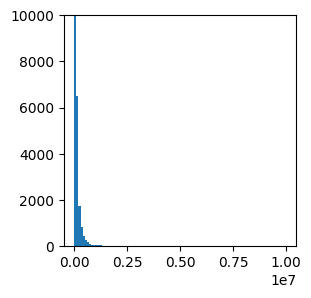

In [319]:
df_list['total_dur'].hist(bins=100, figsize=(3,3))
plt.ylim([0, 10000])
plt.grid(False)

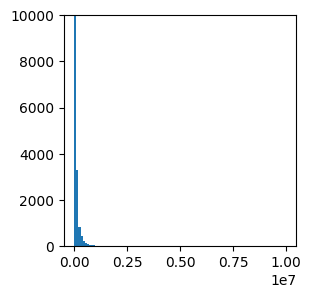

In [320]:
df_list[df_list.group == 'B']['total_dur'].hist(bins=100, figsize=(3,3))
plt.ylim([0, 10000])
plt.grid(False)

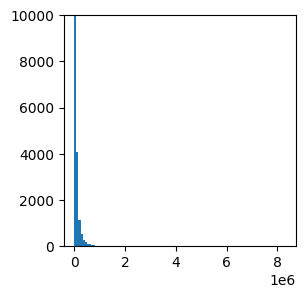

In [321]:
df_list[df_list.group == 'A']['total_dur'].hist(bins=100, figsize=(3,3))
plt.ylim([0, 10000])
plt.grid(False)

 Не буду удалять выбросы, все же для этого нужно немного побольше контекста

In [326]:
df_list[df_list.group == 'B'].total_dur.mean()/df_list[df_list.group == 'A'].total_dur.mean()

1.015279089695739

 Мы видим, что среднее в группе B немного больше, попробуем посмотреть сможет ли хоть какой-то тест сможет обнаружить эту разницу, сначала попробуем bootstrap, но мне кажется тут он хорошо не сработает, но попробовать его точно стоит тк распределение скошенное и t-test или z-test сразу тут применять не хочется. 

Ну и сразу сформулируем гипотезы, чтобы вообще понимать чем мы занимаемся
\begin{align*}
H_0 &: \mu_1 = \mu_2 \\
H_1 &: \mu_1 \neq \mu_2
\end{align*}


In [325]:
def bootstrap_test(data1, data2, n_bootstrap=10000):
    observed_mean_diff = np.mean(data1) - np.mean(data2)
    mean_diffs = []

    for _ in tqdm(range(n_bootstrap)):
        boot_data1 = np.random.choice(data1, size=len(data1), replace=True)
        boot_data2 = np.random.choice(data2, size=len(data2), replace=True)
        boot_mean_diff = np.mean(boot_data1) - np.mean(boot_data2)
        mean_diffs.append(boot_mean_diff)

    # Двусторонний расчет p-значения
    p_value = np.sum(np.abs(mean_diffs) >= np.abs(observed_mean_diff)) / n_bootstrap
    return p_value

# Пример использования функции
p_value = bootstrap_test(group_A.total_dur, group_B.total_dur)
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Средние значения в группах статистически значительно различаются.")
else:
    print("Нет достаточных оснований считать средние значения в группах различными.")


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 392.36it/s]

p-value: 0.5096
Нет достаточных оснований считать средние значения в группах различными.


In [372]:
import numpy as np
from tqdm import tqdm
from scipy.stats import norm

def bootstrap_AB_test(data1, data2, n_bootstrap=100000, alpha=0.05):
    # Вычисляем разность средних в исходных данных
    observed_mean_diff = np.mean(data1) - np.mean(data2)
    mean_diffs = []

    # Генерируем бутстрап-подвыборки и вычисляем разности средних
    for _ in tqdm(range(n_bootstrap)):
        boot_data1 = np.random.choice(data1, size=len(data1), replace=True)
        boot_data2 = np.random.choice(data2, size=len(data2), replace=True)
        boot_mean_diff = np.mean(boot_data1) - np.mean(boot_data2)
        mean_diffs.append(boot_mean_diff)

    # Считаем доверительный интервал
    lower_bound = np.percentile(mean_diffs, (alpha/2)*100)
    upper_bound = np.percentile(mean_diffs, (1-alpha/2)*100)

    # Проверяем, попадает ли нуль в доверительный интервал
    if lower_bound <= 0 <= upper_bound:
        hypothesis = 'H_0'
    else:
        hypothesis = 'H_1'

    return (lower_bound, upper_bound), hypothesis

# Пример использования функции
confidence_interval, hypothesis = bootstrap_AB_test(group_A.total_dur, group_B.total_dur)
print(f"Доверительный интервал: {confidence_interval}")
print(f"Принимаемая гипотеза: {hypothesis}")


100%|██████████████████████████████████| 100000/100000 [07:00<00:00, 237.56it/s]

Доверительный интервал: (-902.7200378754279, 236.9098979215785)
Принимаемая гипотеза: H_0


### По опыту в ситуациях со скошенными распределениями хочется применять не логарфим, корень или другие преобразования, а попробовать применить бакетное преобразование.

In [334]:
# Разделение DataFrame на две группы
group_A = df_list[df_list['group'] == 'A']
group_B = df_list[df_list['group'] == 'B']

# Применение функции генерации бакетов к каждой группе
group_A['bucket'] = group_A['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_A').encode()).hexdigest(), 16) % 250
)
group_B['bucket'] = group_B['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_B').encode()).hexdigest(), 16) % 250
)

# Объединение групп обратно в один DataFrame
week2f = pd.concat([group_A, group_B])


/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_14872/2519959318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['bucket'] = group_A['user_id'].apply(
/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_14872/2519959318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_B['bucket'] = group_B['user_id'].apply(


In [335]:
week2f

,user_id,total_dur,group,bucket
4,1000003,625.0,A,53
5,1000008,3691.0,A,216
6,1000009,2444.0,A,13
7,100001,67000.0,A,160
8,1000013,2430.0,A,52
...,...,...,...,...
266072,999968,16313.0,B,190
266074,99997,30672.0,B,172
266075,999977,4570.0,B,180
266078,999989,4563.0,B,78


Делаем преобразование по бакетам и считаем среднее в каждом, в целом можно и сумму

In [345]:
grouped_week2 = week2f.groupby(['group', 'bucket']).agg({'total_dur':'mean'}).reset_index()

<AxesSubplot: >

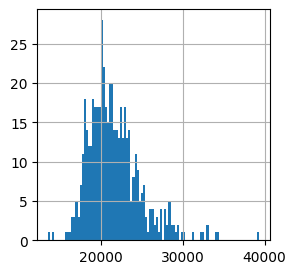

In [346]:
grouped_week2['total_dur'].hist(bins=100, figsize=(3,3))


<AxesSubplot: >

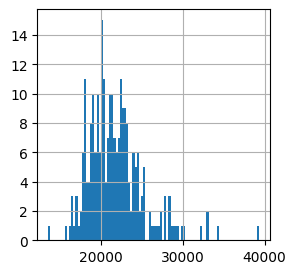

In [347]:
grouped_week2[grouped_week2.group == 'B']['total_dur'].hist(bins=100, figsize=(3,3))

<AxesSubplot: >

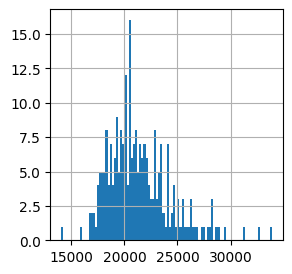

In [348]:
grouped_week2[grouped_week2.group == 'A']['total_dur'].hist(bins=100, figsize=(3,3))



In [353]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(grouped_week2[grouped_week2['group'] == 'A']['total_dur'],
                            grouped_week2[grouped_week2['group'] == 'B']['total_dur'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.1104499161847967, P-value: 0.26734107270904095


In [354]:
from scipy.stats import mannwhitneyu

mw_stat, mw_pvalue = mannwhitneyu(grouped_week2[grouped_week2['group'] == 'A']['total_dur'],
                                   grouped_week2[grouped_week2['group'] == 'B']['total_dur'])

print(f"Mann-Whitney U statistic: {mw_stat}, P-value: {mw_pvalue}")

Mann-Whitney U statistic: 29822.0, P-value: 0.37685486953317915


### Ради интереса попробуем применить тесты без бакетного преобразования

In [357]:
t_stat, p_value = ttest_ind(df_list[df_list['group'] == 'A']['total_dur'],
                            df_list[df_list['group'] == 'B']['total_dur'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.123148866025411, P-value: 0.26137528867944015


In [356]:
mw_stat, mw_pvalue = mannwhitneyu(df_list[df_list['group'] == 'A']['total_dur'],
                                   df_list[df_list['group'] == 'B']['total_dur'])

print(f"Mann-Whitney U statistic: {mw_stat}, P-value: {mw_pvalue}")

Mann-Whitney U statistic: 8821090966.5, P-value: 0.14689099068624964


На самом деле значение p-value если оно больше 0.05 нам ничего особо не говорит, ведь если H0 отвергается, то p-value —степень уверенности в отвержении H0.
(чем p-value меньше, тем увереннее) если H0 не отверг., то ничего сказать нельзя, p-value не есть степень уверенности в справ. H0

In [359]:
df_list = df_list[(df_list['total_dur'] < df_list['total_dur'].std() * 3)]

In [360]:
t_stat, p_value = ttest_ind(df_list[df_list['group'] == 'A']['total_dur'],
                            df_list[df_list['group'] == 'B']['total_dur'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.102197564202033, P-value: 0.2703768000983905


In [361]:
mw_stat, mw_pvalue = mannwhitneyu(df_list[df_list['group'] == 'A']['total_dur'],
                                   df_list[df_list['group'] == 'B']['total_dur'])

print(f"Mann-Whitney U statistic: {mw_stat}, P-value: {mw_pvalue}")

Mann-Whitney U statistic: 8605068181.0, P-value: 0.1491325823759163


### Не получилось найти такого теста, который увидел бы отличия между двумя группами. Оно и понятно - эффект слишком мал и даже с методами уменьшения дисперсии не факт что получилось бы его отловить

Не получилось обнаружить стат. значимые результаты после проведения эксперимента. Скорее всего произошло это из-за того, что изменилось поведение пользователей, у которых и так продолжительность довольно высокая. Может быть, что какая-то другая метрика (по типу выручки) могла увеличится благодаря этому (может выручка получется за счет просмотра рекламы), но если интересно смотреть метрику total_dur, то нужно вводить такие изменения, которые увеличат эту метрику у средних пользователей